# Overall workflow
![alt text](https://github.com/AIScienceTutorial/Bayesian-optimization---case-study/blob/main/workflow.png?raw=true)

# Load necessary Python packages

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                              AutoMinorLocator)
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats import norm
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C ,WhiteKernel as Wht,Matern as matk
import time
import pylab as pl
from IPython import display
%matplotlib inline 

# Read SMILES and features into Pandas dataframes

In [4]:
features = "https://github.com/AIScienceTutorial/Bayesian-optimization---case-study/blob/main/features.csv?raw=true"
smiles = "https://github.com/AIScienceTutorial/Bayesian-optimization---case-study/blob/main/SMILES.csv?raw=true"

# Load SMILES and features
dfSMILES = pd.read_csv(smiles)
Xinfo = dfSMILES.SMILES
print(Xinfo)
X = pd.read_csv(features)
print(X)

0                         N#CC(c1ccccc1)C(Br)Oc1ccccc1
1      O=[N+]([O-])c1ccc(C(c2ccccc2)C(Br)Oc2ccccc2)cc1
2                     CC(Oc1ccccc1)C(C#N)c1ccc(C#N)cc1
3                   COC(C#N)C(C)(C)c1ccc(-c2ccccc2)cc1
4        COC(Oc1ccccc1)C(C)(C#N)c1ccc([N+](=O)[O-])cc1
                            ...                       
995                       COCOC(OC)C(c1ccccc1)c1ccccc1
996              COCOC(OC)C(C#N)(c1ccccc1)c1ccc(OC)cc1
997                         COCOCC(C)c1ccc(C(=O)OC)cc1
998                     COCOC(Br)C(C)(C#N)c1ccc(OC)cc1
999        COCOCC(C#N)(c1ccccc1)c1ccc([N+](=O)[O-])cc1
Name: SMILES, Length: 1000, dtype: object
     sssr    clogp        mr          mw   tpsa      chi0n     chi1n  \
0       2  4.09378   74.5810  301.010226  33.02   9.661630  5.613702   
1       3  5.52670  101.1664  397.031356  52.37  13.287527  7.800217   
2       2  3.63296   76.0430  262.110613  56.81  11.153528  6.357125   
3       2  4.16978   81.3140  265.146664  33.02  12.128965  6.676

# Perform principle component analysis 

Cuulative explained variance:
[0.88194657 0.97645279 0.99772018 0.99935141 0.99959557 0.99971379
 0.9998166  0.99988552 0.99993238 0.99995635 0.99997056 0.99998027
 0.99998836 0.99999178 0.99999401 0.99999614 0.99999777 0.99999843
 0.99999888 0.99999919 0.99999944 0.99999966 0.99999982 0.9999999
 0.99999996 0.99999997 0.99999999 1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.       

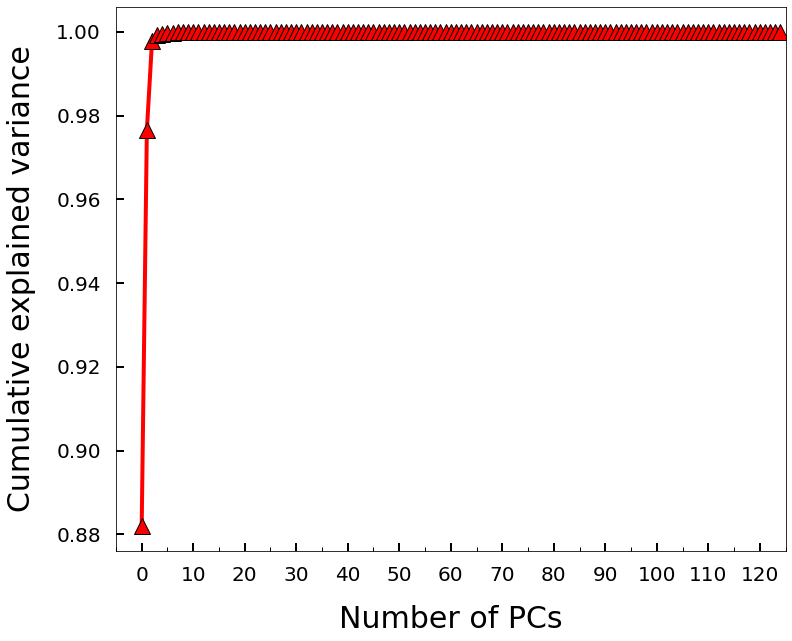

In [5]:
pca = PCA().fit(X)

#Plotting

fig, ax1 = plt.subplots()

#plt.rc('font', family='serif')

ax1.set_xlabel('Number of PCs', fontsize=30,labelpad=20)
ax1.set_ylabel('Cumulative explained variance', fontsize=30,labelpad=20)
ax1.xaxis.set_major_locator(MultipleLocator(10))
ax1.xaxis.set_minor_locator(MultipleLocator(5))
ax1.tick_params(axis='both', which='major', direction='in', size=8, left='on', bottom='on', width=2, pad=15)
ax1.tick_params(axis='both', which='minor', direction='in', size=4, left='on', bottom='on',width=1, pad=15)
ax1.tick_params(axis="y", labelsize=20)
ax1.tick_params(axis="x", labelsize=20)

plt.gcf().set_size_inches((12, 10))
#ax1.set_ylim([0.4,1.05])
ax1.set_xlim([-5.,125])
ax1.plot(np.cumsum(pca.explained_variance_ratio_), marker='^',markersize=16, 
         markeredgecolor='black', linestyle='-',linewidth=4, color='red')
print('Cuulative explained variance:')
print(np.cumsum(pca.explained_variance_ratio_))


In [6]:
n_PC = 15  # Number of PCs used
st = StandardScaler()
Xdata = st.fit_transform(X)

pca = PCA(n_components=n_PC)
Xdata = pca.fit_transform(Xdata)

PC1 = Xdata[:,0]

# Set up GPR and Expected Improvement functions

In [7]:
def gpregression(Xtrain,Ytrain,Nfeature):    
    cmean=[1.0]*Nfeature
    cbound=[[1e-3, 1e3]]*Nfeature
    kernel = C(1.0, (1e-3,1e3)) * matk(cmean,cbound,1.5) + Wht(1.0, (1e-3, 1e3))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=40, normalize_y=False)
    gp.fit(Xtrain, Ytrain)
    return gp

# Predict result using GP regression model
def gprediction(gpnetwork,xtest):
    y_pred, sigma = gpnetwork.predict(xtest, return_std=True)
    return y_pred, sigma

# https://github.com/fmfn/BayesianOptimization/blob/master/bayes_opt/util.py

# Compute expected improvement
def expectedImprovement(xdata,gpnetwork,ybest,epsilon):
    ye_pred, esigma = gprediction(gpnetwork, xdata)
    expI = np.empty(ye_pred.size, dtype=float)
    for ii in range(0,ye_pred.size):
        if esigma[ii] > 0:
            zzval=(ye_pred[ii]-ybest)/float(esigma[ii])
            expI[ii]=(ye_pred[ii]-ybest-epsilon)*norm.cdf(zzval)+esigma[ii]*norm.pdf(zzval)
        else:
            expI[ii]=0.0
    return expI

def probabilityImprovement(xdata,gpnetwork,ybest,epsilon):
    ye_pred, esigma = gprediction(gpnetwork, xdata)
    poI = np.empty(ye_pred.size, dtype=float)
    for ii in range(0,ye_pred.size):
        if esigma[ii] > 0:
            zzval=(ye_pred[ii]-ybest-epsilon)/float(esigma[ii])
            poI[ii]=norm.cdf(zzval)
        else:
            poI[ii]=0.0
    return poI

def upperConfidenceBound(xdata,gpnetwork,ybest,epsilon):
    ye_pred, esigma = gprediction(gpnetwork, xdata)
    ucb = np.empty(ye_pred.size, dtype=float)
    for ii in range(0,ye_pred.size):
        if esigma[ii] > 0:
            ucb[ii]=itag*(ye_pred[ii]+epsilon*esigma[ii])
        else:
            ucb[ii]=0.0
    return ucb

# Build the Bayesian optimization cycles

# Step 1: Select 10 initial random molecules for GPR model training

In [8]:
#computedEox = "https://github.com/AIScienceTutorial/Bayesian-optimization---case-study/blob/main/computedEox.csv?raw=true"
#dfEox = pd.read_csv(computedEox) # Load pre-computed Eox 
#Ydata = dfEox.Eox.values 

ndata = len(Ydata)

ntrain = 10 # Number of initial training data points
nremain = ndata - ntrain
dataset = np.random.permutation(ndata)
a1data = np.empty(ntrain, dtype=int)
a2data = np.empty(nremain, dtype=int)
a1data[:] = dataset[0:ntrain]
a2data[:] = dataset[ntrain:ndata]

Xtrain = np.ndarray(shape=(ntrain, nPC), dtype=float)
Xtraininfo = np.chararray(ntrain, itemsize=100)
Ytrain = np.empty(ntrain, dtype=float)
Xtrain[0:ntrain, :] = Xdata[a1data, :]
Xtraininfo[0:ntrain] = Xinfo[a1data]
Ytrain[0:ntrain] = Ydata[a1data]

yoptLoc = np.argmax(Ytrain)
yopttval = Ytrain[yoptLoc]
xoptval = Xtraininfo[yoptLoc]
yoptstep=0
yopinit = yopttval
xoptint = xoptval

Xremain = np.ndarray(shape=(nremain, nPC), dtype=float)
Xremaininfo = np.chararray(nremain, itemsize=100)
Yremain = np.empty(nremain, dtype=float)
Xremain[0:nremain, :] = Xdata[a2data, :]
Xremaininfo[0:nremain] = Xinfo[a2data]
Yremain[0:nremain] = Ydata[a2data]

print('*** Initial training set ***')
print(115*'-')
print('{:<5s}{:<80s}{:<15s}'.format('Id','SMILES','Eox'))
print(115*'-')

*** Finding SMILES with maximum Eox ***
Original shape of X and Y : (1000, 15) (1000,)


In [67]:
markerSize = 100
axisLabelSize = 35
tickLabelSize = 30
def boCycles(Xdata,Ydata,Xinfo,ndata,nPC):
    epsilon = 0.01 # Control exploration/exploitation balance
    ntrain = 10 # Number of initial training data points
    nremain = ndata - ntrain
    dataset = np.random.permutation(ndata)
    a1data = np.empty(ntrain, dtype=int)
    a2data = np.empty(nremain, dtype=int)
    a1data[:] = dataset[0:ntrain]
    a2data[:] = dataset[ntrain:ndata]

    Xtrain = np.ndarray(shape=(ntrain, nPC), dtype=float)
    Xtraininfo = np.chararray(ntrain, itemsize=100)
    Ytrain = np.empty(ntrain, dtype=float)
    Xtrain[0:ntrain, :] = Xdata[a1data, :]
    Xtraininfo[0:ntrain] = Xinfo[a1data]
    Ytrain[0:ntrain] = Ydata[a1data]
    
    yoptLoc = np.argmax(Ytrain)
    yopttval = Ytrain[yoptLoc]
    xoptval = Xtraininfo[yoptLoc]
    yoptstep=0
    yopinit = yopttval
    xoptint = xoptval

    Xremain = np.ndarray(shape=(nremain, nPC), dtype=float)
    Xremaininfo = np.chararray(nremain, itemsize=100)
    Yremain = np.empty(nremain, dtype=float)
    Xremain[0:nremain, :] = Xdata[a2data, :]
    Xremaininfo[0:nremain] = Xinfo[a2data]
    Yremain[0:nremain] = Ydata[a2data]
    
    print('*** Initial training set ***')
    print(115*'-')
    print('{:<5s}{:<80s}{:<15s}'.format('Id','SMILES','Eox'))
    print(115*'-')
    for i in range(ntrain):
        if opt=='max':
            print('{:<5d}{:<80s}{:<15f}'.format(i,Xtraininfo[i].decode(),Ytrain[i]))
        elif opt=='min':
            print('{:<5d}{:<80s}{:<15f}'.format(i,Xtraininfo[i].decode(),-Ytrain[i]))
    print(115*'-')  

    print("Total number of inital training points: ", ntrain)
    if opt=='max':
        print("Initial best SMILES is "+xoptval.decode()+' with Eox = '+str(yopttval))
    elif opt=='min':
        print("Initial best SMILES is "+xoptval.decode()+' with Eox = '+str(-yopttval))

    for ii in range(0, Niteration):
        print('------------')
        print('Iteration '+str(ii+1))
        print('Training GPR model on '+str(ntrain+ii)+' data points')
        gpnetwork = gpregression(Xtrain, Ytrain, nPC)
        
        print('Making Eox prediction on the remaining '+str(ndata-ntrain-ii)+' data points')
        yt_pred, tsigma = gprediction(gpnetwork, Xtrain)
        
        ybestloc = np.argmax(Ytrain) # The current best y value
        ybest = yt_pred[ybestloc]
        ytrue = Ytrain[ybestloc]
        
        if yopttval < ytrue:
            yopttval = ytrue
            xoptval = Xtraininfo[ybestloc]
            
        print('Computing EI on the remaining '+str(ndata-ntrain-ii)+' data points')
        expI = expectedImprovement(Xremain, gpnetwork, ybest, epsilon)
        expImax = np.max(expI)
        expimaxloc = np.argmax(expI)
        print('Based on EIs, the next SMILES to be evaluated and added to the training set is '+Xremaininfo[expimaxloc].decode())
    
        """
        # Live plotting       
        fig, ax = plt.subplots()
        ax.set_xlabel('PC-1',fontsize=axisLabelSize)
        ax.set_ylabel(r'E$\rm ^{ox}$ (V vs NHE)',fontsize=axisLabelSize)
        fig.set_size_inches(12, 10)
        plt.scatter(PC1,Ydata,color='k',alpha=0.5,s=30,facecolor='None')
        
        loc1 = np.where(Ydata==Ytrain[ybestloc])[0]
        loc2 = np.where(Ydata==Yremain[expimaxloc])[0]

        plt.scatter(PC1[loc1],Ytrain[ybestloc],color='r',s=30)
        plt.scatter(PC1[loc2],Yremain[expimaxloc],color='k', s=30)   
        plt.scatter(PC1[loc2],Yremain[expimaxloc],color='k', s=30)

        #plt.scatter(np.where(Ydata==Ytrain[ybestloc])[0],Ytrain[ybestloc],color='r',s=300)
        #plt.scatter(np.where(Ydata==Yremain[expimaxloc])[0],Yremain[expimaxloc],color='b', s=300)        
        for label in ax.xaxis.get_ticklabels(): # label is a Text instance
            label.set_fontsize(tickLabelSize)
        for label in ax.yaxis.get_ticklabels(): # label is a Text instance
            label.set_fontsize(tickLabelSize)
        display.clear_output(wait=True)
        display.display(pl.gcf())
        time.sleep(1.0)
        """
        
        xnew = np.append(Xtrain, Xremain[expimaxloc]).reshape(-1, nPC)
        xnewinfo = np.append(Xtraininfo, Xremaininfo[expimaxloc])
        ynew = np.append(Ytrain, Yremain[expimaxloc])
        xrnew = np.delete(Xremain, expimaxloc, 0)
        xrnewinfo = np.delete(Xremaininfo, expimaxloc)
        yrnew = np.delete(Yremain, expimaxloc)
        if ii==0:
            Xexplored=Xremaininfo[expimaxloc]
            Yexplored=Yremain[expimaxloc]
        else:
            Xexploredtemp=np.append(Xexplored, Xremaininfo[expimaxloc])
            Yexploredtemp=np.append(Yexplored, Yremain[expimaxloc])
            del Xexplored,Yexplored
            Xexplored=Xexploredtemp
            Yexplored=Yexploredtemp
        del Xtrain, Ytrain, Xremaininfo, gpnetwork
        Xtrain = xnew
        Xtraininfo = xnewinfo
        Ytrain = ynew
        Xremain = xrnew
        Xremaininfo = xrnewinfo
        Yremain = yrnew
        del xnew, xnewinfo, ynew, xrnew, xrnewinfo, yrnew

    if not yopinit==yopttval:
        yoptstep = np.argmax(Yexplored) + 1       
    else:
        yoptstep=0
    dataorder = np.argsort(Yexplored)
    Yexploredtemp=Yexplored[dataorder]
    Xexploredtemp = Xexplored[dataorder]
    print('*** Summary ***')
    print(115*'-')
    print('{:<15s}{:<80s}{:<15s}'.format('Iteration','SMILES','Eox'))
    print(115*'-')
    for i,sml in enumerate(Xexplored):
        if opt=='max':
            print('{:<15d}{:<80s}{:<15f}'.format(i+1,sml.decode(),Yexplored[i]))
        elif opt=='min':
            print('{:<15d}{:<80s}{:<15f}'.format(i+1,sml.decode(),-Yexplored[i]))

    print(115*'-')  
    print("\n")
    if opt=='min':
        yopttval*=-1
    print("The best SMILES is "+xoptval.decode()+" with Eox = "+str(yopttval)+", which was found in iteration "+str(yoptstep))
    return xoptint,yopinit,xoptval,yopttval

# Main program

In [68]:
computedEox = "https://github.com/AIScienceTutorial/Bayesian-optimization---case-study/blob/main/computedEox.csv?raw=true"
dfEox = pd.read_csv(computedEox) # Load pre-computed Eox 
opt = 'max' 
if opt=='max':
    Ydata = dfEox.Eox.values 
elif opt=='min':
    Ydata = -1*dfEox.Eox.values 
print('*** Finding SMILES with '+opt+'imum Eox ***')
ndata = len(Ydata)
print("Original shape of X and Y :",np.shape(Xdata),np.shape(Ydata))
Nruns = 1
Niteration = 30          # number of iteration in a given Bayesian  Optimization
Xinitguess = np.chararray(Nruns, itemsize=100)
Yinitguess = np.empty(Nruns, dtype=float)
Xoptimal = np.chararray(Nruns, itemsize=100)
Yoptimal = np.empty(Nruns, dtype=float)

for ii in range(0,Nruns):
    Xinitguess[ii], Yinitguess[ii], Xoptimal[ii], Yoptimal[ii] =boCycles(Xdata, Ydata, Xinfo, ndata, n_PC)

*** Finding SMILES with maximum Eox ***
Original shape of X and Y : (1000, 15) (1000,)
*** Initial training set ***
-------------------------------------------------------------------------------------------------------------------
Id   SMILES                                                                          Eox            
-------------------------------------------------------------------------------------------------------------------
0    CC(c1ccc([N+](=O)[O-])cc1)C(C#N)Oc1ccccc1                                       2.114023       
1    COCC(C)c1ccc(C(=O)OC)cc1                                                        2.371158       
2    CCc1ccc(C(C)(C#N)C(C#N)OCOC)cc1                                                 2.428544       
3    COC(c1ccccc1)C(C#N)(C#N)c1ccc([N+](=O)[O-])cc1                                  2.737922       
4    COC(=O)c1ccc(C(c2ccccc2)C(Br)Oc2ccccc2)cc1                                      2.119057       
5    COC(=O)c1ccc(C(C)(C)C(Oc2ccccc2)c2ccccc2)